
# Clasificación multiclase — Diamonds (cut)

Objetivo: predecir **cut** (`Fair`, `Good`, `Very Good`, `Premium`, `Ideal`) con 5 modelos clásicos.

Pasos
1) Carga y exploración rápida  
2) Preprocesamiento (imputación + codificación con LabelEncoder + escalado numéricas)  
3) División train/test  
4) Entrenamiento: Regresión Logística, KNN, SVC, Árbol, Random Forest  
5) Evaluación: accuracy, matriz de confusión, classification_report y resumen final


In [3]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

CSV_PATH = "diamonds.csv"
TARGET = "cut"  # multiclase


In [4]:

# 1) Carga y exploración rápida
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"No se encontró el dataset en {CSV_PATH}.")

df = pd.read_csv(CSV_PATH)

print("Dimensiones (filas, columnas):", df.shape)
print("Columnas:", df.columns.tolist())
print("\nTipos de datos:")
print(df.dtypes)

print("\nPrimeras 5 filas:")
display(df.head())

print("\nNulos por columna:")
print(df.isna().sum())

# Si el dataset es muy grande, permite muestrear (opcional)
MAX_ROWS = 5000
if len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=42).reset_index(drop=True)
    print(f"\nSe tomó una muestra de {MAX_ROWS} filas para agilizar el entrenamiento.")


Dimensiones (filas, columnas): (53940, 10)
Columnas: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

Tipos de datos:
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

Primeras 5 filas:


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75



Nulos por columna:
carat       0
cut         0
color       0
clarity     0
depth       1
table       0
price       0
x           1
y           0
z          10
dtype: int64

Se tomó una muestra de 5000 filas para agilizar el entrenamiento.


In [5]:

# 2) Separar X (features) y y (objetivo)
if TARGET not in df.columns:
    raise ValueError(f"No encuentro la columna objetivo '{TARGET}'.")

feature_cols = [c for c in df.columns if c != TARGET]
X = df[feature_cols].copy()
y = df[TARGET].copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)
print("Clases en y:", y.unique())


Numéricas: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
Categóricas: ['color', 'clarity']
Clases en y: ['Ideal' 'Very Good' 'Premium' 'Fair' 'Good']


In [6]:

# 3) Preprocesamiento explícito (sin Pipeline)

# Imputación numéricas -> media
num_imputer = SimpleImputer(strategy="mean")
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# Imputación categóricas -> moda
cat_imputer = SimpleImputer(strategy="most_frequent")
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# LabelEncoder en cada categórica de X
encoders_X = {}
for c in cat_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))
    encoders_X[c] = le

# LabelEncoder para y (target multiclase)
le_y = LabelEncoder()
y_enc = le_y.fit_transform(y.astype(str))

# Estandarizar SOLO las numéricas
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("Preprocesamiento listo. Ejemplo de X preprocesado:")
display(X.head())
print("Clases codificadas (y):", dict(zip(le_y.classes_, range(len(le_y.classes_)))))


Preprocesamiento listo. Ejemplo de X preprocesado:


,carat,color,clarity,depth,table,price,x,y,z
0,-1.152108,3,6,0.220606,-0.634537,-0.830435,-1.538221,-1.522055,-1.514944
1,-0.448995,2,7,-1.241286,-0.193451,-0.424403,-0.247431,-0.267411,-0.390009
2,-0.821232,1,7,0.220606,-1.075622,-0.662533,-0.844531,-0.868226,-0.831439
3,-0.759192,1,7,-0.684374,-0.193451,-0.646212,-0.704037,-0.735693,-0.788720
4,1.556944,1,3,0.359834,-1.075622,0.737807,1.508745,1.455517,1.532349


Clases codificadas (y): {'Fair': 0, 'Good': 1, 'Ideal': 2, 'Premium': 3, 'Very Good': 4}


In [7]:

# 4) División train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Shapes -> X_train:", X_train.shape, "| X_test:", X_test.shape)


Shapes -> X_train: (4000, 9) | X_test: (1000, 9)


In [8]:

# 5) Modelos a comparar
models = {
    "LogisticRegression": LogisticRegression(max_iter=200, multi_class="auto"),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVC": SVC(kernel="rbf"),
    "DecisionTree": DecisionTreeClassifier(random_state=42, max_depth=None),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
}
list(models.keys())


['LogisticRegression', 'KNN', 'SVC', 'DecisionTree', 'RandomForest']

In [9]:

# 6) Entrenamiento
fitted = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    fitted[name] = clf
    print(f"{name}: entrenado.")


c:\Users\juanq\Desktop\UNIR-Bootcamp\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\juanq\Desktop\UNIR-Bootcamp\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: entrenado.
KNN: entrenado.
SVC: entrenado.
DecisionTree: entrenado.
RandomForest: entrenado.



=== LogisticRegression ===
Accuracy: 0.6380 | F1-macro: 0.5021
Matriz de confusión:
 [[ 17   1   5   6   3]
 [  8   4  23  28  30]
 [  0   0 345  26  20]
 [  1   0  31 194  36]
 [  2   5  77  60  78]]


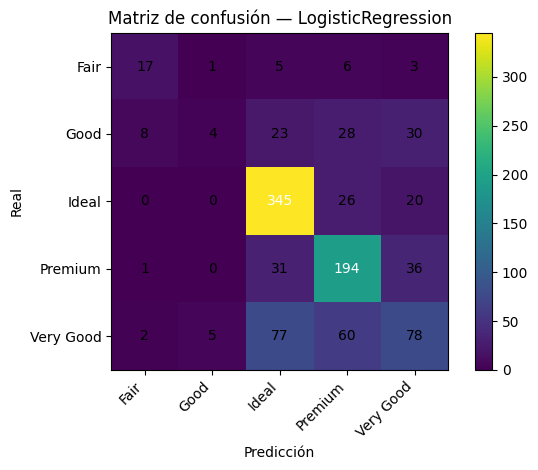

Classification report:
              precision    recall  f1-score   support

        Fair       0.61      0.53      0.57        32
        Good       0.40      0.04      0.08        93
       Ideal       0.72      0.88      0.79       391
     Premium       0.62      0.74      0.67       262
   Very Good       0.47      0.35      0.40       222

    accuracy                           0.64      1000
   macro avg       0.56      0.51      0.50      1000
weighted avg       0.60      0.64      0.60      1000



TypeError: unhashable type: 'dict'

In [10]:

def evaluar_modelo(name, clf, X_test, y_test, label_decoder=None):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)
    
    # Dibujo matriz
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz de confusión — {name}")
    plt.colorbar()
    classes = label_decoder.classes_ if label_decoder is not None else np.arange(cm.shape[0]).astype(str)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.tight_layout()
    plt.show()
    
    # Reporte detallado
    print("Classification report:")
    print(classification_report(
        y_test, y_pred, zero_division=0,
        target_names=label_decoder.classes_ if label_decoder is not None else None
    ))
    return acc, f1m

# Evaluación de todos y resumen
results = {}
for name, clf in fitted.items():
    acc, f1m = evaluar_modelo(name, clf, X_test, y_test, label_decoder=le_y)
    results[name] = {{ "accuracy": acc, "f1_macro": f1m }}

print("\nResumen de métricas (ordenado por F1-macro):")
res_df = pd.DataFrame(results).T.sort_values(by=["f1_macro","accuracy"], ascending=False)
display(res_df)
best = res_df.index[0]
print(f"\nMejor modelo por F1-macro: {{best}} ->", res_df.loc[best].to_dict())
